# Variational Inference using PYMC4 & Bambi
This analysis uses a 5 year data set I previously created. The main objective of this notebook is to figure out how to get an interesting model, that runs in a reasonable amount of time.

**Data Splitting**
+ 2017-2019 use to inform priors (how?)
+ 2020 training
+ 2021 holdout

## Quick Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import bambi as bmb

import aesara.tensor as at

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


In [2]:
data = pd.read_csv('joined_crash_2017+2021.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482367 entries, 0 to 482366
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   X                        482367 non-null  float64
 1   Y                        482367 non-null  float64
 2   OBJECTID                 482367 non-null  int64  
 3   DOCUMENT_NBR             482367 non-null  int64  
 4   CRASH_YEAR               482367 non-null  int64  
 5   CRASH_SEVERITY           482367 non-null  object 
 6   CRASH_DT                 482367 non-null  object 
 7   WEATHER_CONDITION        482367 non-null  object 
 8   LIGHT_CONDITION          482367 non-null  object 
 9   RD_TYPE                  482367 non-null  object 
 10  ROADWAY_ALIGNMENT        482367 non-null  object 
 11  ROADWAY_SURFACE_TYPE     482367 non-null  object 
 12  ROADWAY_DEFECT           482367 non-null  object 
 13  ROADWAY_DESCRIPTION      482367 non-null  object 
 14  TRFC

In [3]:
# correcting dtypes
type_dict = {c:'category' for c in data.columns if data[c].dtypes=='O'}
type_dict['CRASH_DT'] = 'datetime64'
type_dict['RURALURBANDESC'] = 'category'
type_dict['MEDIAN_TYPE'] = 'category'

data = data.astype(type_dict)

I will cut these columns because (1) they convey redundant information, (2) I don't understand them.

|**drop column**|**reason**|
|----------|----------|
|`RD_TYPE`|Interpretation Unclear|
|`AREA_TYPE`|Redundant with `RURALURBANDESC`|
|`SYSTEM`|Could be interesting, but I need to cut stuff|
|`SPEED_BEFORE`|behavior variable, not environmental variable|
|`SPEED_MAX_SAFE`|Redundant with `SPEED_POSTED` and environmental variables|
|`PAVEMENT_ROUGHNESSVALUE`|Interpretation Unclear/High Nullness|
|`MEDIAN_TYPE`|Redundant with `ROADWAY_DESCRIPTION`|


In [4]:
# drop columns above
data = data.drop(['RD_TYPE', 'AREA_TYPE', 'SYSTEM',
                  'SPEED_BEFORE', 'SPEED_MAX_SAFE',
                  'PAVEMENT_ROUGHNESSVALUE',
                  'MEDIAN_TYPE'], axis=1)

# lower col names
data.columns = data.columns.str.lower()

In [5]:
for c in data.columns:
    if data[c].dtype.name=='category':
        print(f"\n\t{c}")
        print(data[c].value_counts())


	crash_severity
O    322249
B     95455
C     37901
A     23585
K      3177
Name: crash_severity, dtype: int64

	weather_condition
1. No Adverse Condition (Clear/Cloudy)    398302
5. Rain                                    65774
6. Snow                                     6695
4. Mist                                     6531
3. Fog                                      2265
7. Sleet/Hail                               1741
9. Other                                     649
11. Severe Crosswinds                        243
10. Blowing Sand, Soil, Dirt, or Snow        154
8. Smoke/Dust                                 13
Name: weather_condition, dtype: int64

	light_condition
2. Daylight                            316350
5. Darkness - Road Not Lighted          72373
4. Darkness - Road Lighted              64174
3. Dusk                                 14305
1. Dawn                                 13090
6. Darkness - Unknown Road Lighting      1209
7. Unknown                                866


Next, I will flatten the levels of some categoricals.

|**flattened column**|**strategy**|
|--------------------|------------|
|`trfc_ctrl_status_type`|1. Yes 2. Yes - inhibited 3. No|
|`work_zone_location`|1. Yes 2. No|

Other ideas:  
+ Weather: Clear, Precip, Low Vis, Wind  
+ Light: Daylight, Dark, Low Sun
+ roadway_description: Two-Way, One-Way, Unknown

In [6]:
data['trfc_ctrl_status_type'] = data['trfc_ctrl_status_type'].map({'1. Yes - Working':'1. Yes', 
                                   '6. No Traffic Control Device Present':'3. No', 
                                   '3. Yes - Not Working':'2. Yes - inhibited', 
                                   '2. Yes - Working and Obscured':'2. Yes - inhibited', 
                                   '4. Yes - Not Working and Obscured':'2. Yes - inhibited', 
                                   '5. Yes - Missing':'2. Yes - inhibited'}).astype('category')

data['work_zone_location'] = data['work_zone_location'].map({'5. Not Work Area':'2. No', 
                                                             '3. Activity Area':'1. Yes', 
                                                             '4. Termination Area':'1. Yes', 
                                                             '1. Advance Warning Area':'1. Yes', 
                                                             '2. Transition Area':'1. Yes'}).astype('category')

In [7]:
# trim category levels
# Ex: "5. Rain" is trimmed to "5"

cat_cols = [c for c in data.columns if data[c].dtype.name=='category']

for c in cat_cols:
    data[c] = data[c].astype('str').str[:1].astype('category')
        

In [8]:
# scale numerics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data[['speed_posted', 'numberoflane']] = scaler.fit_transform(data[['speed_posted', 'numberoflane']])

I separate the data by years.

In [9]:
# prior_data = data.loc[data.crash_year.isin([2017, 2018, 2019])]
# train = data.loc[data.crash_year==2020]
# holdout = data.loc[data.crash_year==2021]
train = data.loc[data.crash_year.isin([2019, 2020, 2021])]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271456 entries, 210911 to 482366
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   x                       271456 non-null  float64       
 1   y                       271456 non-null  float64       
 2   objectid                271456 non-null  int64         
 3   document_nbr            271456 non-null  int64         
 4   crash_year              271456 non-null  int64         
 5   crash_severity          271456 non-null  category      
 6   crash_dt                271456 non-null  datetime64[ns]
 7   weather_condition       271456 non-null  category      
 8   light_condition         271456 non-null  category      
 9   roadway_alignment       271456 non-null  category      
 10  roadway_surface_type    271456 non-null  category      
 11  roadway_defect          271456 non-null  category      
 12  roadway_description     2

---

I further reduce the number of observations for quick testing.

In [11]:
# take a 3% stratified sample of 2020 data
# roughly 2500 observation

# from sklearn.model_selection import train_test_split
# trainx, _, trainy, _ = train_test_split(train.drop('crash_severity', axis=1), train['crash_severity'],
#                                       stratify = train['crash_severity'], train_size = 0.03)

# train = trainx.merge(trainy ,left_index=True, right_index=True)
train.shape

(271456, 20)

---
# Model with Bambi

In [12]:
# trainc = train[['crash_severity', 'speed_posted', 'light_condition']]
# # trainc = pd.get_dummies(trainc, columns = ['crash_severity', 'light_condition'])

In [13]:
train.columns

Index(['x', 'y', 'objectid', 'document_nbr', 'crash_year', 'crash_severity',
       'crash_dt', 'weather_condition', 'light_condition', 'roadway_alignment',
       'roadway_surface_type', 'roadway_defect', 'roadway_description',
       'trfc_ctrl_status_type', 'work_zone_location', 'intersection_analysis',
       'speed_posted', 'direction_of_travel_cd', 'ruralurbandesc',
       'numberoflane'],
      dtype='object')

In [14]:
from sklearn.preprocessing import LabelBinarizer

def cc(args):

    lb = LabelBinarizer()
    return lb.fit_transform(args).astype('uint8')

# returns sparse encoding. For example,
# A -> [1, 0, 0, 0, 0]
# B -> [0, 1, 0, 0, 0]
# C -> [0, 0, 1, 0, 0]
# K -> [0, 0, 0, 1, 0]
# O -> [0, 0, 0, 0, 1]

In [15]:
ab = train[['crash_severity']].copy()
ab['enc'] =[str(x) for x in cc(train.crash_severity).tolist()]
ab.drop_duplicates()

,crash_severity,enc
210911,O,"[0, 0, 0, 0, 1]"
210917,B,"[0, 1, 0, 0, 0]"
210926,C,"[0, 0, 1, 0, 0]"
210934,A,"[1, 0, 0, 0, 0]"
211191,K,"[0, 0, 0, 1, 0]"


In [16]:
formu = ("cc(crash_severity) ~ weather_condition +"
         " light_condition +"
         " roadway_alignment +"
         " roadway_surface_type +"
         " roadway_defect +"
         " roadway_description +"
         " trfc_ctrl_status_type +"
         " work_zone_location +"
         " intersection_analysis +"
         " speed_posted +"
         " direction_of_travel_cd +"
         " ruralurbandesc +"
         " numberoflane")

In [17]:
model = bmb.Model(formula=formu, data=train, family='multinomial')

fitted_vi = model.fit(method='vi', n=25000)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(


Finished [100%]: Average Loss = 2.5876e+05


In [18]:
samples_xarray = fitted_vi.sample(1000, random_seed=1)
samples = fitted_vi.sample(1000, random_seed=1, return_inferencedata=False)

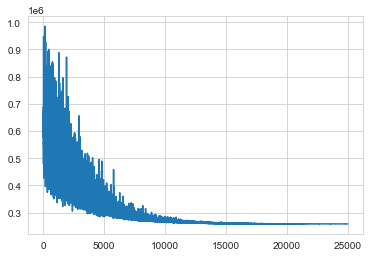

In [19]:
plt.plot(fitted_vi.hist)

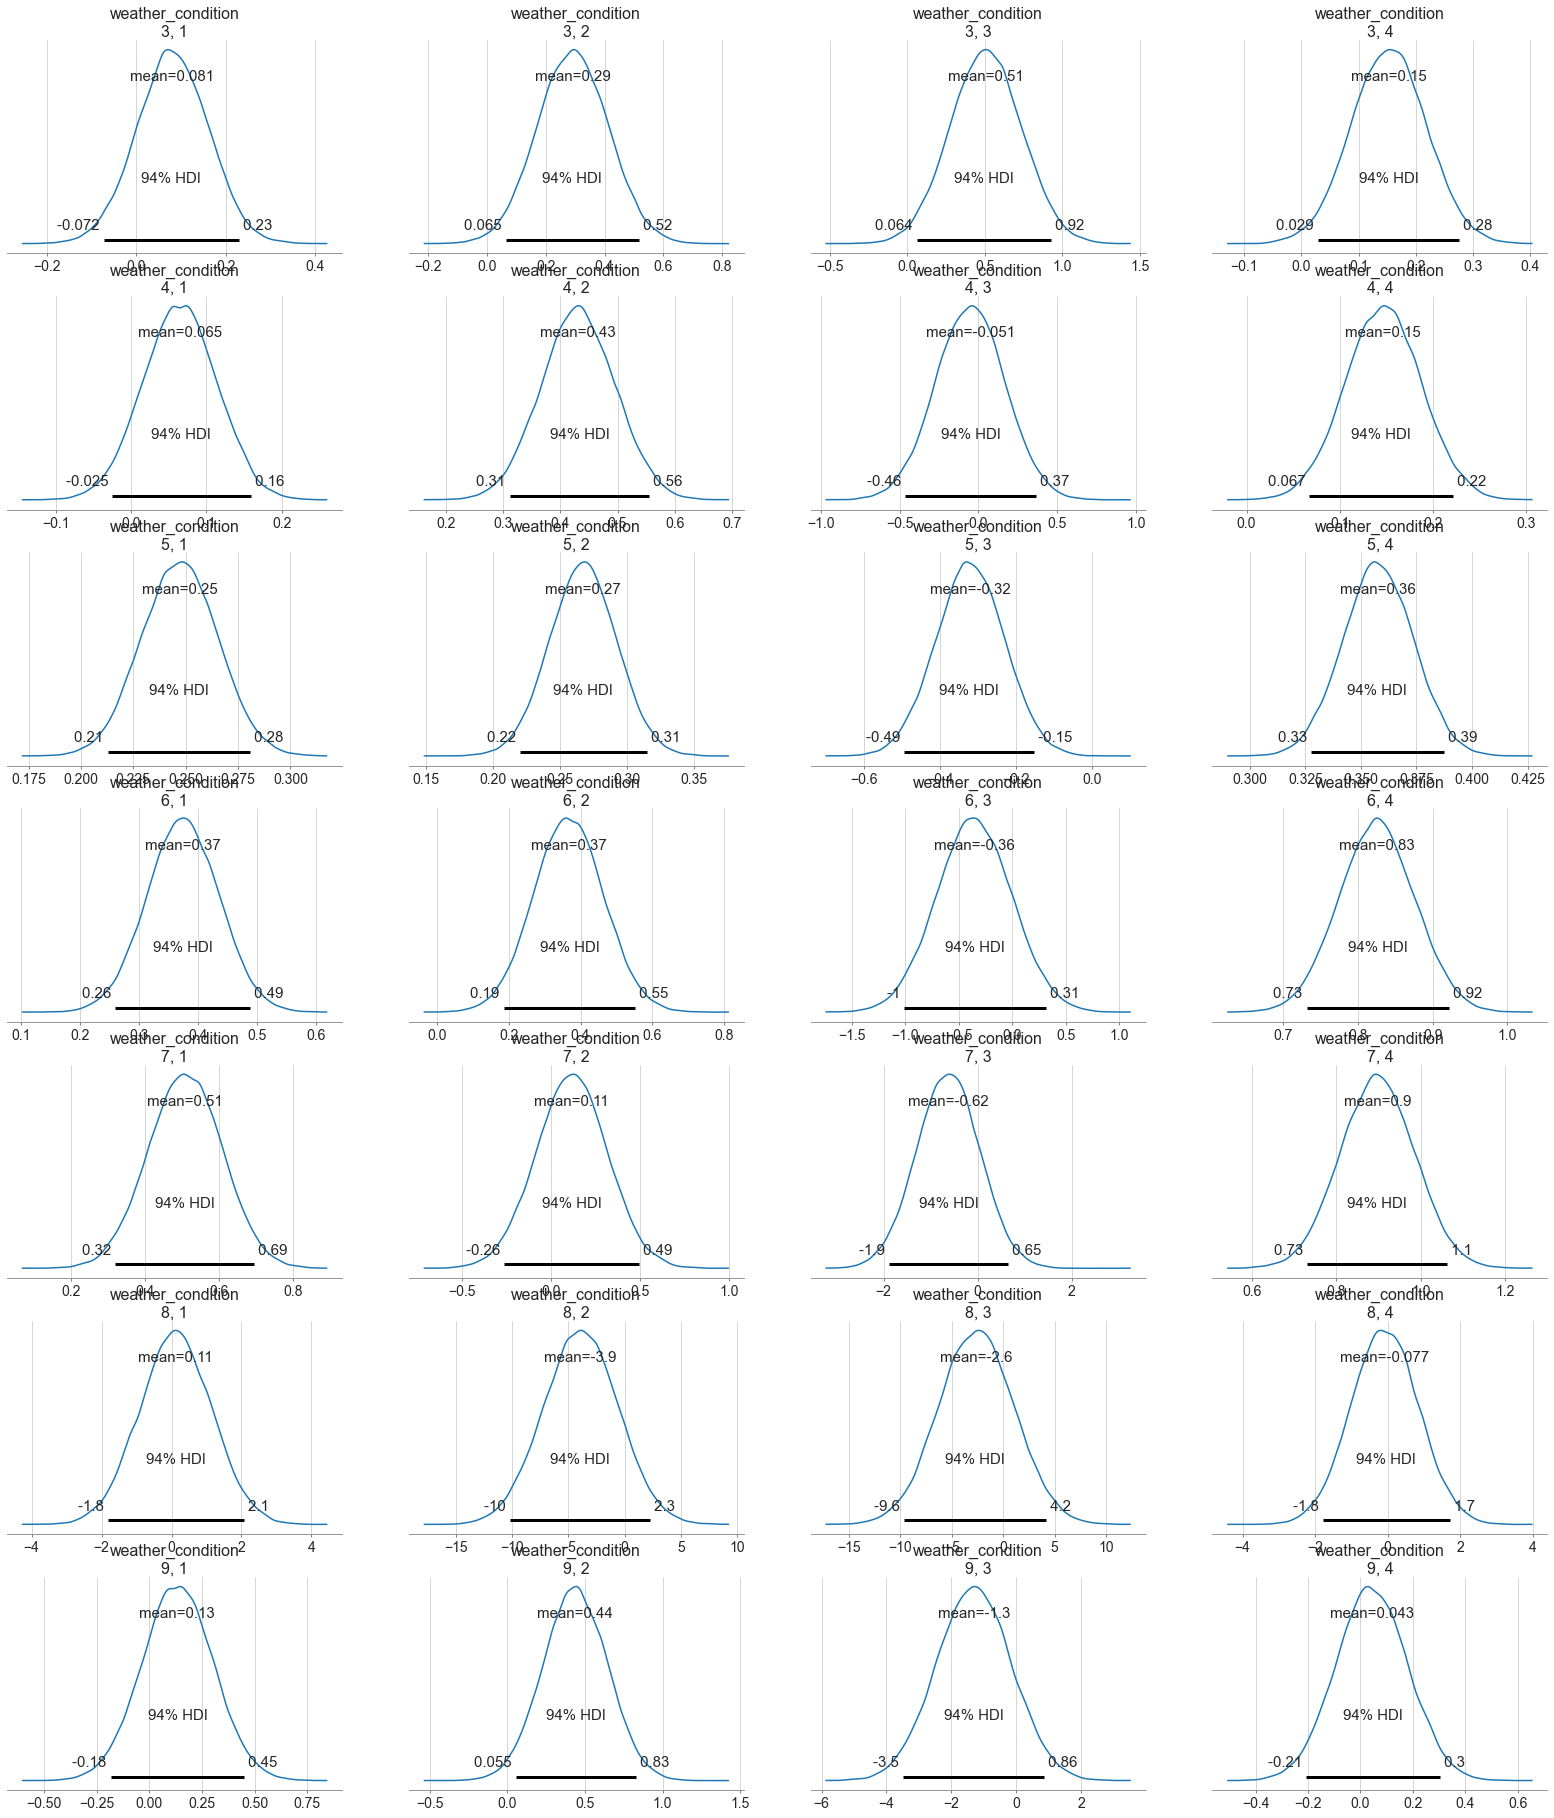

In [20]:
import arviz as az
az.plot_posterior(fitted_vi.sample(50000), var_names="weather_condition")
plt.show()

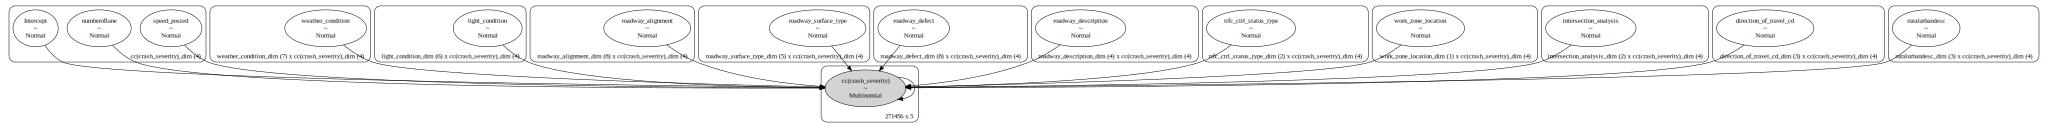

In [21]:
pm.model_to_graphviz(fitted_vi.model)

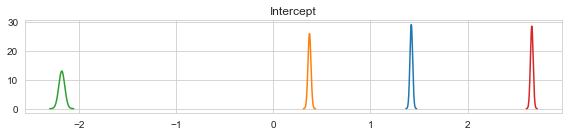

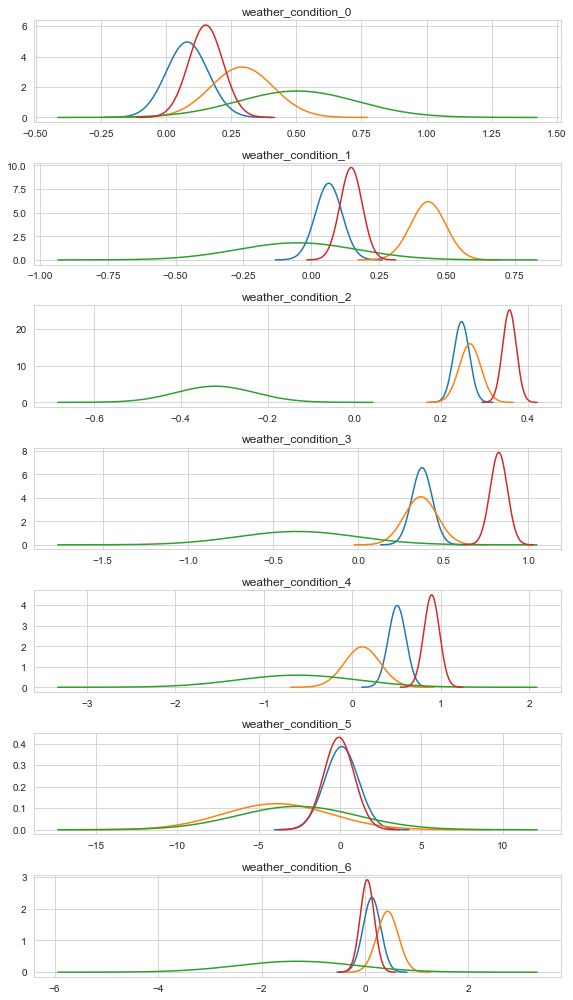

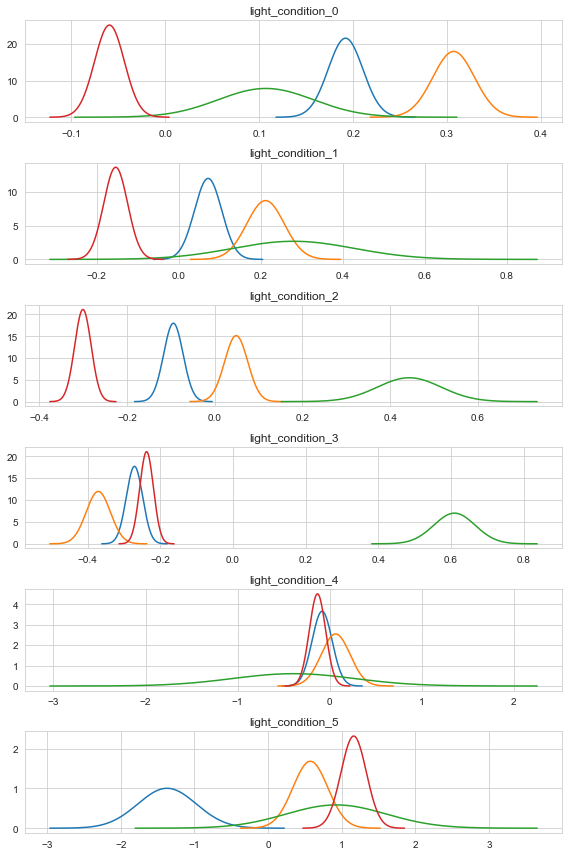

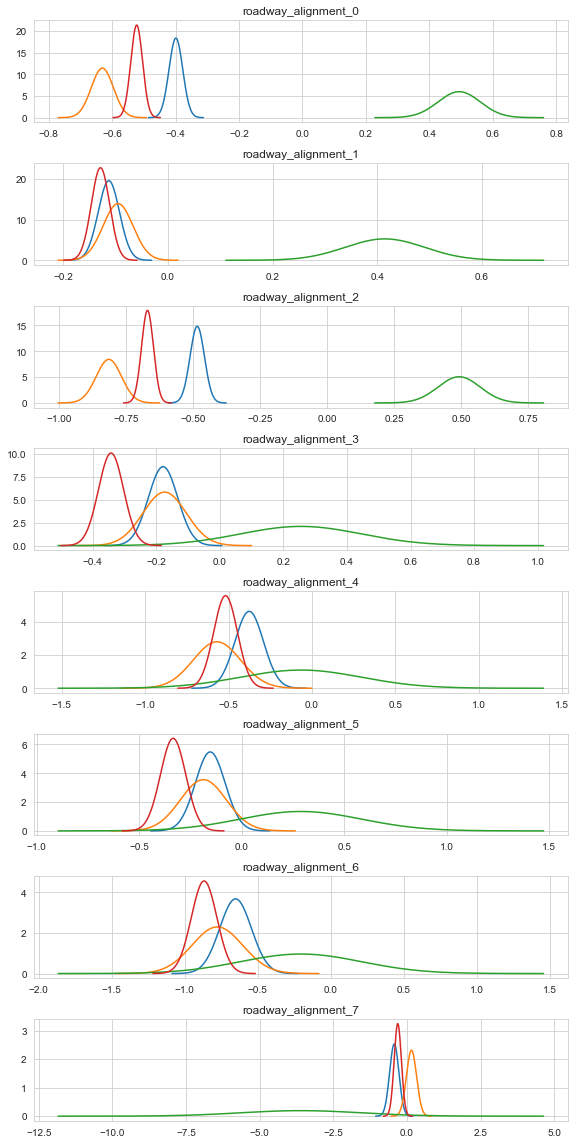

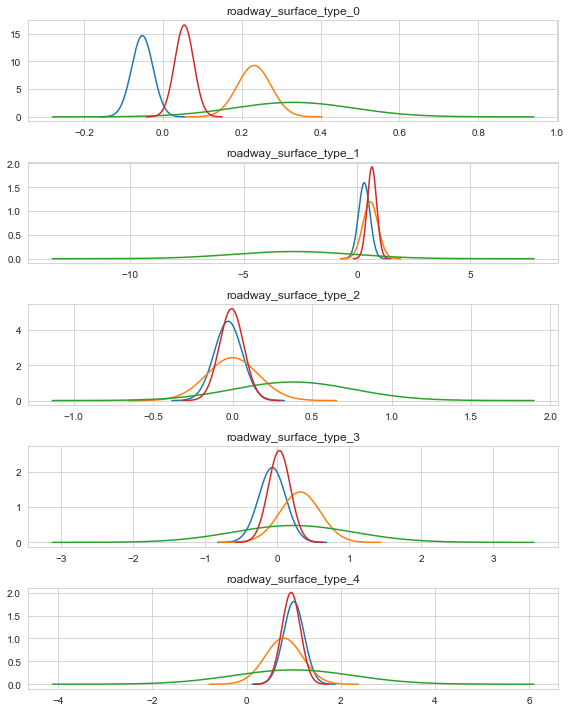

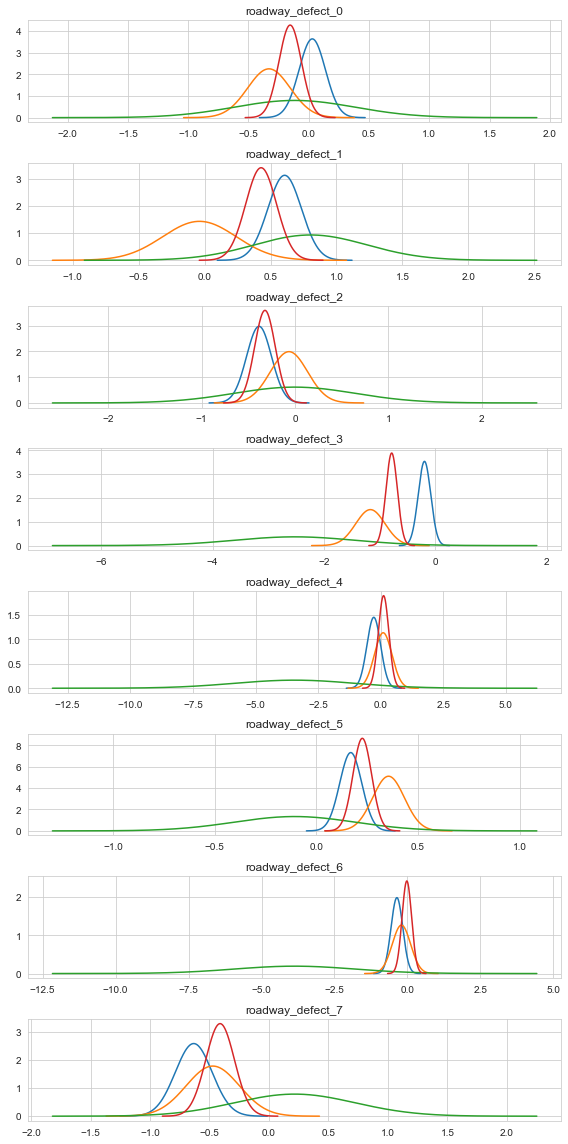

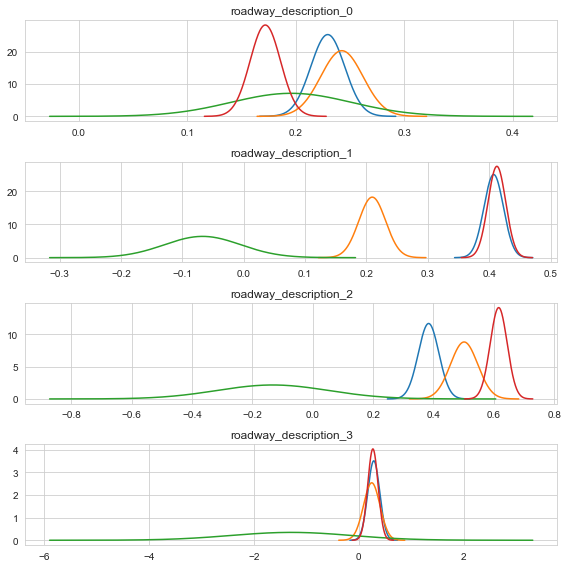

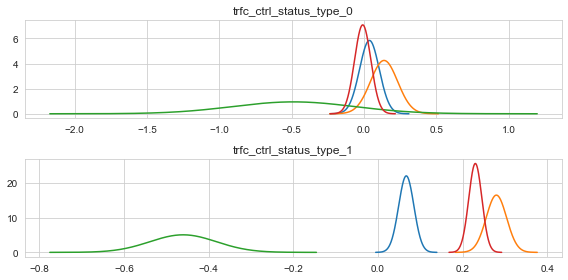

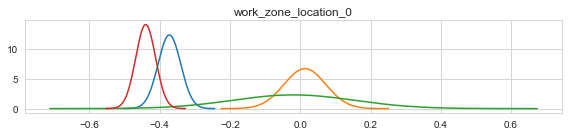

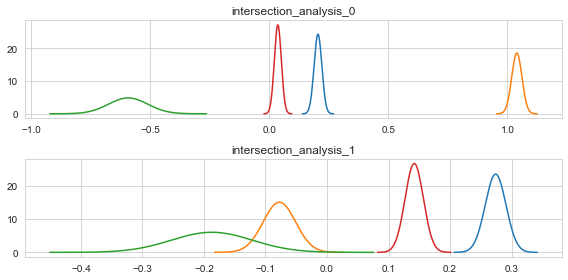

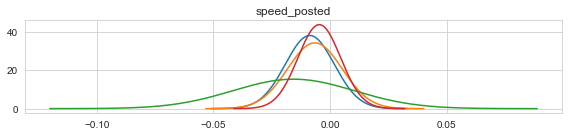

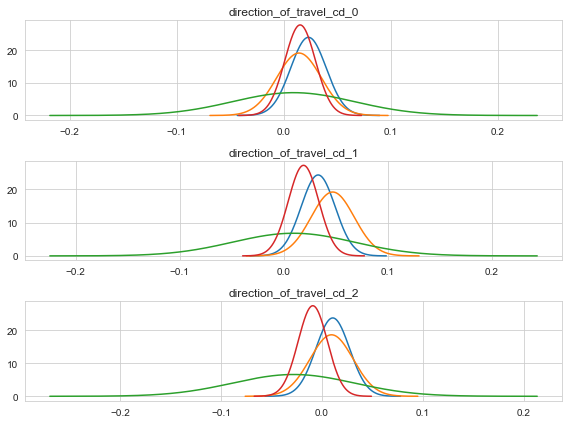

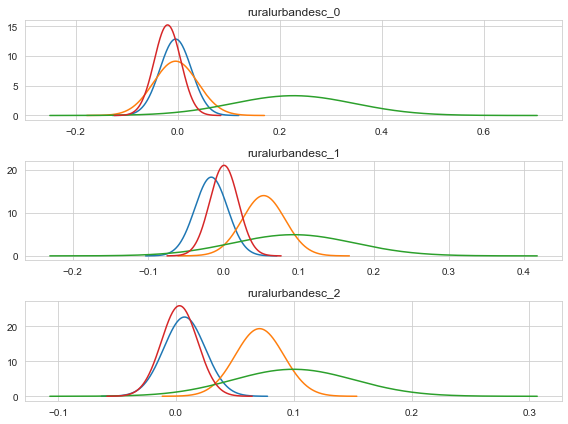

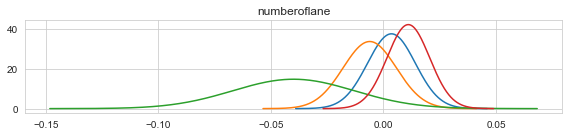

In [22]:
# ploterizer

order = fitted_vi.ordering
means = fitted_vi.mean.eval()
stds = fitted_vi.std.eval()

for obj in order:
    
    # if lvl_flag == 2, param is categorical w/ more than 2 levels
    lvl_flag = len(order[obj][2])
    
    # slice start/stop
    start = order[obj][1].start
    stop = order[obj][1].stop
    
    if lvl_flag == 1:
        plt.figure(figsize=(8,2), tight_layout=True)
        for i, (mu, sigma) in enumerate(zip(means[start:stop], stds[start:stop])):
            sd3 = (-4 * sigma + mu, 4 * sigma + mu)
            x = np.linspace(sd3[0], sd3[1], 400)
            y = stats.norm(mu, sigma).pdf(x)
            plt.plot(x,y)
            plt.title(order[obj][0])
        plt.show()
        
    if lvl_flag == 2:
        n_lvl = order[obj][2][0]
        fig, axs = plt.subplots(nrows=n_lvl, figsize = (8, 2*(n_lvl)))
        
        for lvl in np.arange(n_lvl):
            
            if n_lvl == 1:
                axs.set_title(order[obj][0]+f"_{lvl}")

                mean_lvl= means[start+(4*lvl):start+(4*(lvl+1))]
                std_lvl = stds[start+(4*lvl):start+(4*(lvl+1))]

                sd3 = (-4*std_lvl+mean_lvl, 4*std_lvl+mean_lvl)
                x = np.linspace(sd3[0], sd3[1], 400)
                y = stats.norm(mean_lvl, std_lvl).pdf(x)
                axs.plot(x,y)
                
            else:
                axs[lvl].set_title(order[obj][0]+f"_{lvl}")

                mean_lvl= means[start+(4*lvl):start+(4*(lvl+1))]
                std_lvl = stds[start+(4*lvl):start+(4*(lvl+1))]

                sd3 = (-4*std_lvl+mean_lvl, 4*std_lvl+mean_lvl)
                x = np.linspace(sd3[0], sd3[1], 400)
                y = stats.norm(mean_lvl, std_lvl).pdf(x)
                axs[lvl].plot(x,y)
        fig.tight_layout()
        plt.show()    

In [23]:
# save trace of approximation
atrace = fitted_vi.sample(10000, return_inferencedata=True)
atrace.to_netcdf("bambitrace.nc")

'bambitrace.nc'